In [1]:
%load_ext autoreload
%autoreload 2
from alphatoe import plot, game, evals, interpretability
from alphatoe.interpretability import numpy
from alphatoe import fancy_plots as fp
import torch as t
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [3]:
#example_game = [10,4,0,2,6,5,8,3]
example_game = [10, 0, 1, 2, 3, 4, 5, 6]
logits = model(t.tensor(example_game))
preds = t.softmax(logits, axis=-1)
last_move_preds = preds[0, -1]
print(last_move_preds)

tensor([1.3083e-22, 1.8313e-10, 2.0960e-21, 2.0014e-10, 1.2713e-19, 2.2223e-10,
        3.7983e-22, 1.6497e-06, 1.9384e-06, 1.0000e+00], device='mps:0',
       grad_fn=<SelectBackward0>)


In [4]:
fp.board_heatmap(preds[0, -1], example_game[1:], title="", color='#FF7F50')

In [15]:
example_game = [10, 0, 1, 2, 3, 4, 5, 6]
early_game = [10, 4]
logits, cache = model.run_with_cache(
    t.tensor(example_game), remove_batch_dim=True
)
attention_pattern = cache["pattern", 0, "attn"]
print(attention_pattern.shape)
print(attention_pattern[0, -1])


torch.Size([8, 8, 8])
tensor([0.0794, 0.1375, 0.1347, 0.1267, 0.1151, 0.1263, 0.1535, 0.1268],
       device='mps:0')


In [16]:
0.39*np.log(0.5) + 0.61*np.log(0.5)

-0.6931471805599453

In [31]:
fp.board_attn_heatmap(attention_pattern[1, -1], example_game[1:], title="", color='#FF7F50')

In [8]:
def get_attention_pattern(game):
    logits, cache = model.run_with_cache(
        t.tensor(game), remove_batch_dim=True
    )
    attention_pattern = cache["pattern", 0, "attn"]
    return list(numpy(attention_pattern[1, -1]))

def calculate_entropy(attention):
    return -sum([p * np.log(p) for p in attention])

def get_entropy_over_games(games):
    entropy_dict = defaultdict(list)
    for game in tqdm(games):
        for i in range(1, len(game)):
            if  1 < i < 11:
                attn_pattern = get_attention_pattern(game[:i])
                entropy = calculate_entropy(attn_pattern)
                entropy_dict[i-2].append(entropy)
    return entropy_dict

In [9]:
samples = evals.sample_games(model, 0.9, 1000)

 16%|█▌        | 158/1000 [00:08<00:46, 18.29it/s]


KeyboardInterrupt: 

In [ ]:
samples[0][:11]

[10, 1, 4, 0, 2, 5, 8, 6, 3, 7, 9]

In [ ]:
entropy_values = get_entropy_over_games(samples)

100%|██████████| 1000/1000 [00:30<00:00, 32.36it/s]


In [ ]:
def theoretical_entropy(num_moves):
    prob = 1 / (num_moves+1)
    return -sum([prob * np.log(prob) for _ in range(num_moves+1)])

In [ ]:
theoretical_entropy(1)

0.6931471805599453

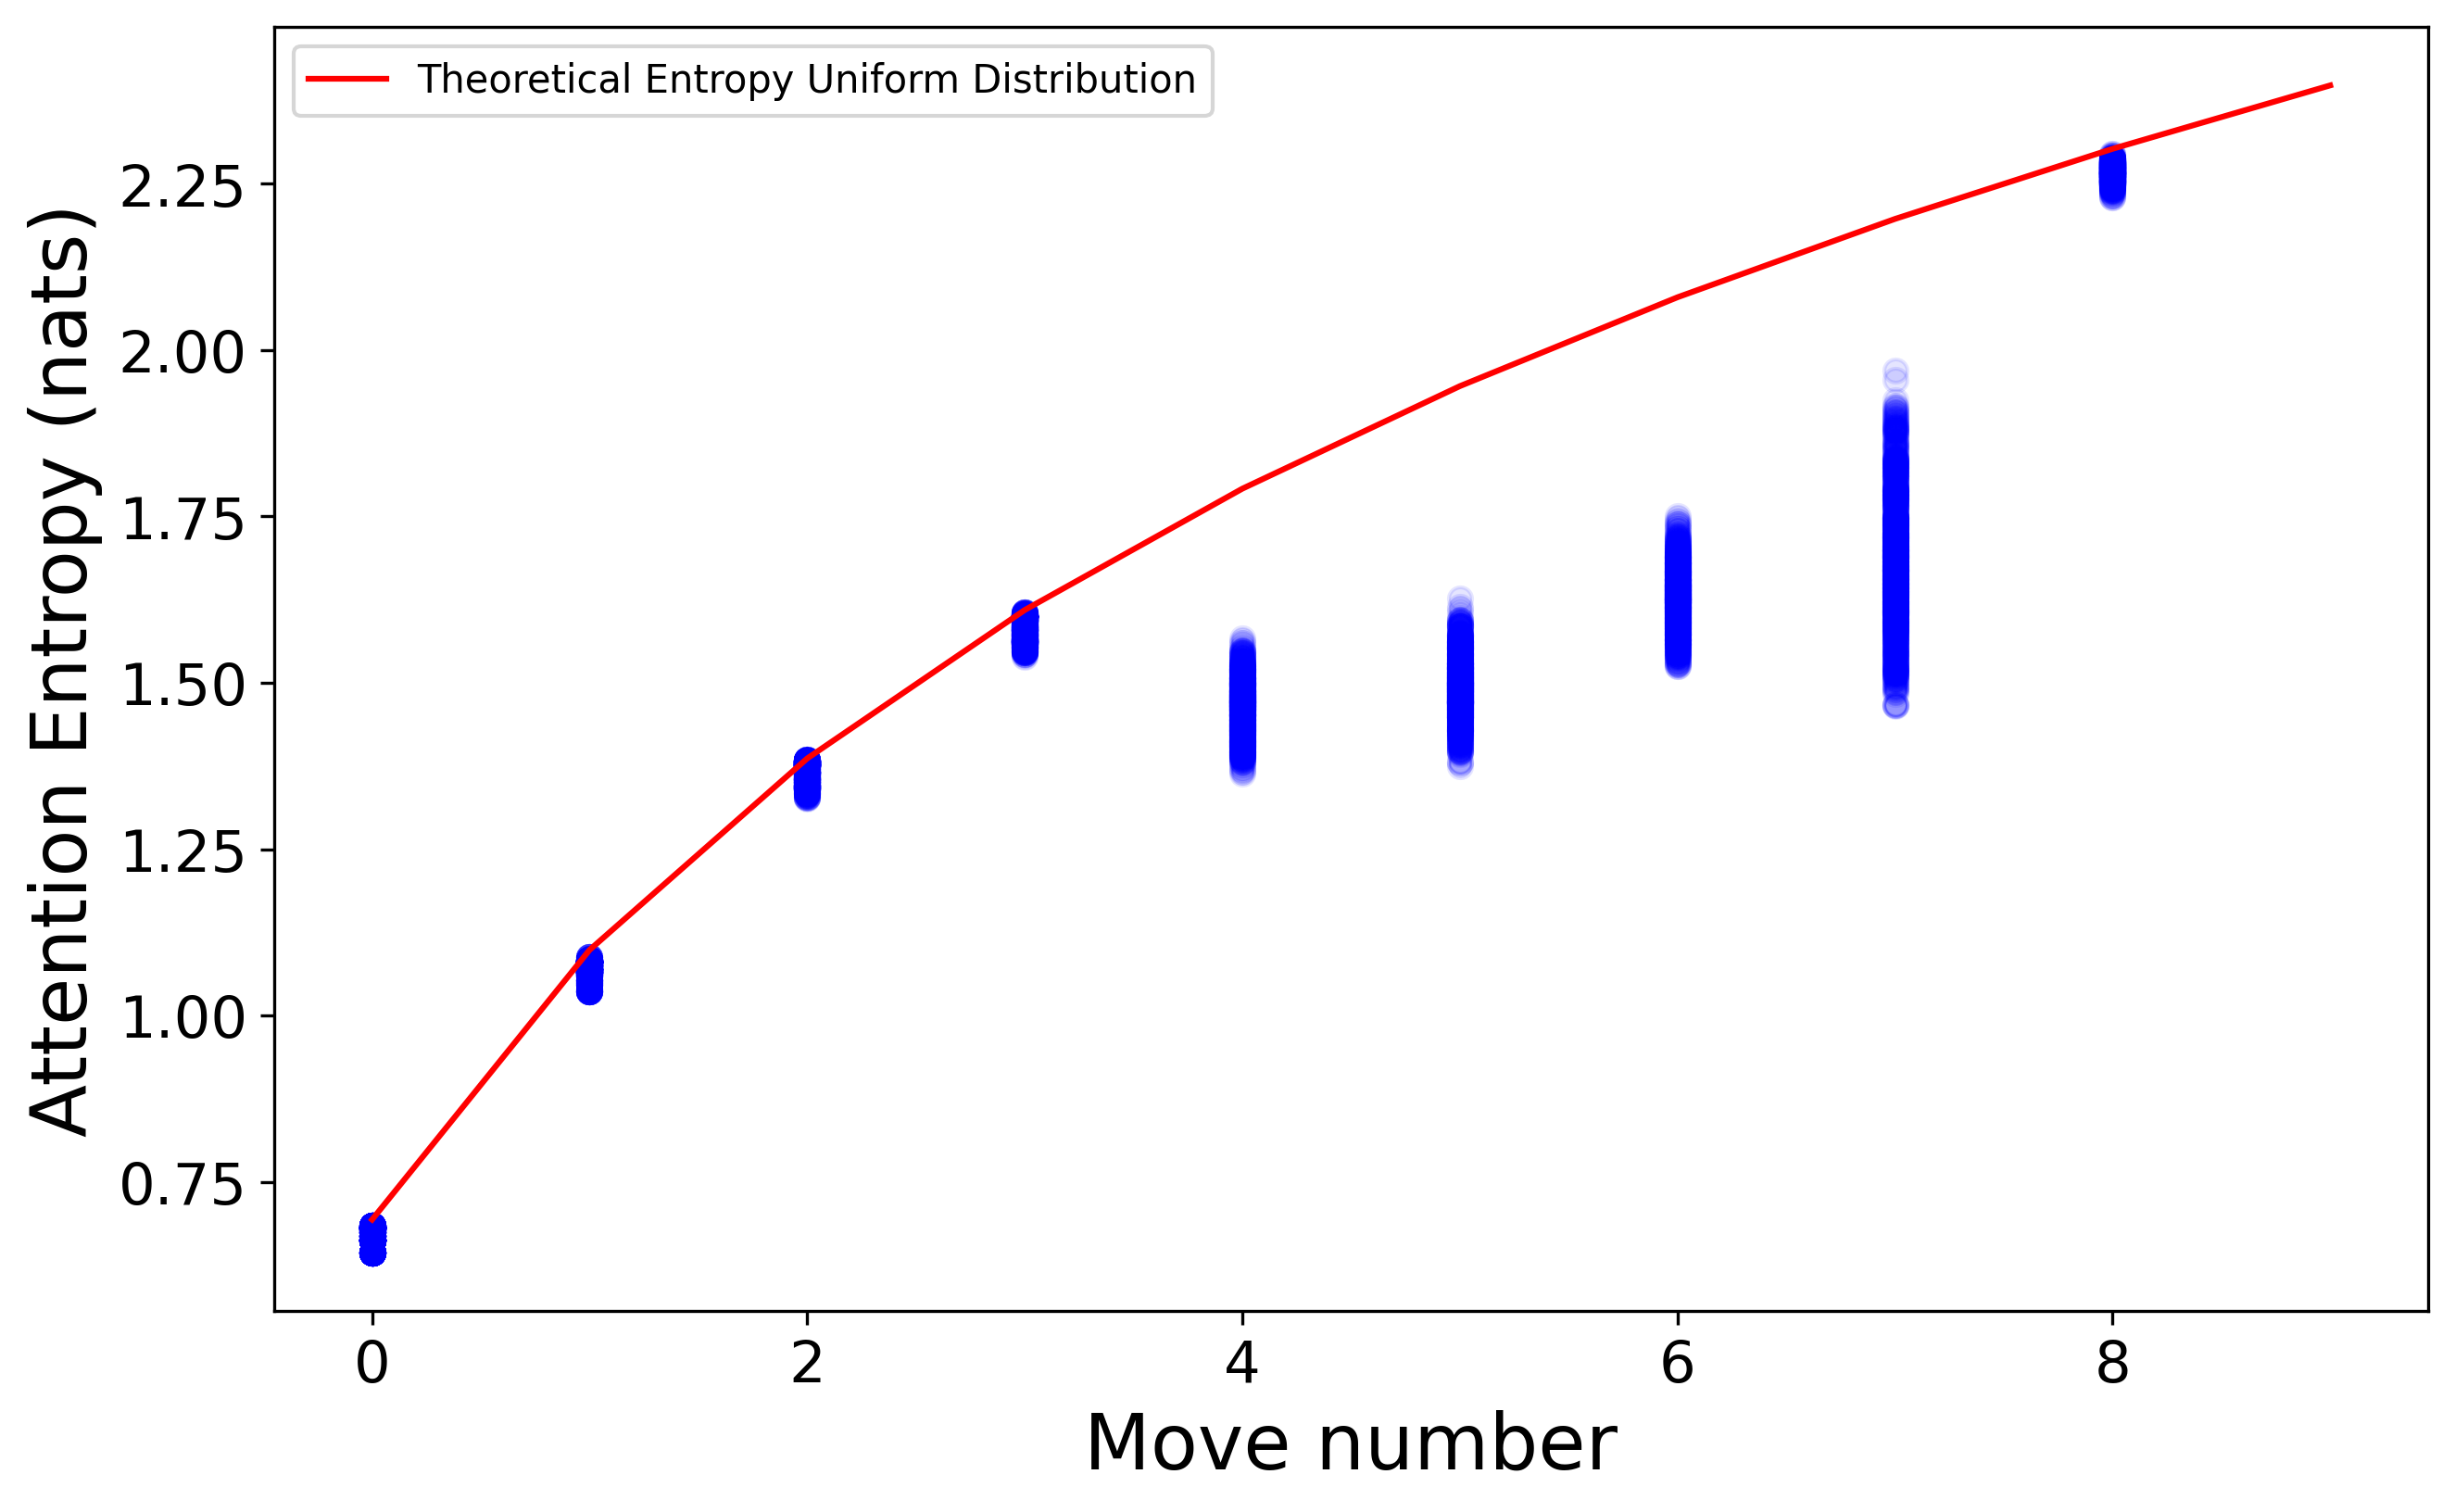

In [ ]:
# Plot the entropy values
fig, ax = plt.subplots(dpi=300, figsize=(10, 6))
for i, values in entropy_values.items():
    ax.scatter([i] * len(values), values, color='blue', alpha=0.1);
ax.plot([i for i in range(10)], [theoretical_entropy(i+1) for i in range(10)], color='red', label='Theoretical Entropy Uniform Distribution')
ax.set_xlabel("Move number", fontsize=20)
ax.set_ylabel("Attention Entropy (nats)", fontsize=20)
ax.legend(fontsize=10)
#font size
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
